**Fatemeh Mohammadi**

**810199489**

# Introduction:


Convolutional Neural Networks (CNNs) and Natural Language Processing (NLP) are two pivotal areas in the field of artificial intelligence and machine learning. CNNs have revolutionized image and video processing by enabling machines to automatically learn to recognize patterns and features. NLP, on the other hand, focuses on the interaction between computers and human language, aiming to read, decipher, and understand the intricacies of human language.

In recent years, the integration of these two domains has opened new frontiers in developing sophisticated models that can process and analyze multimedia data comprehensively. This integration is particularly beneficial for applications that involve both visual and textual data, such as social media analysis, where posts often include images, videos, and text.




## Problem Statement



With the proliferation of social media platforms, there is an increasing amount of data being generated every day. This data can be a rich source of information for various applications, including sentiment analysis, trend detection, and public health monitoring. However, the sheer volume and unstructured nature of social media data present significant challenges in extracting meaningful insights.

One critical application of social media analysis is the detection of suicidal ideation and mental health issues. Identifying individuals at risk can provide timely intervention opportunities and potentially save lives. Despite its importance, accurately detecting such content remains challenging due to the complexity and variability of natural language and the need for nuanced understanding of context.

## Overview of the Dataset

The dataset used in this project is sourced from social media platforms, specifically Twitter, and is referred to as the "twitter-suicidal-data" dataset. This dataset is curated to aid in the detection of suicidal ideation from user-generated posts on social media.

#### Data Collection

- **Source:** The data consists of posts from Twitter, a popular social media platform where users share short messages known as tweets.
- **Timeframe:** The tweets were collected over a specified period to capture a variety of content that reflects different contexts and sentiments.
- **Volume:** The dataset contains thousands of tweets, providing a substantial amount of data for training and evaluating machine learning models.

#### Data Characteristics

- **Textual Data:** Each entry in the dataset includes a tweet, which is a short text message. The tweets vary in length and linguistic style, including abbreviations, slang, and informal language typical of social media communication.
- **Labels:** Each tweet is labeled with an indication of whether it reflects suicidal ideation or not. The labels are binary, with `1` indicating suicidal ideation and `0` indicating the absence of such content.

#### Data Preprocessing

Given the raw nature of social media data, several preprocessing steps are necessary to prepare the dataset for analysis:

- **Tokenization:** Splitting the text into individual tokens (words, hashtags, mentions).
- **Stop Words Removal:** Removing common words that do not contribute significantly to the meaning (e.g., "and," "the").
- **Stemming/Lemmatization:** Reducing words to their root forms to ensure uniformity (e.g., "running" to "run").
- **Handling Special Characters and Emojis:** Removing or converting special characters and emojis to a format that can be processed by machine learning algorithms.
- **Normalization:** Converting text to lowercase to maintain consistency.

#### Challenges and Considerations

- **Noise:** Social media data is inherently noisy, containing a lot of irrelevant information, misspellings, and informal language, which requires extensive cleaning.
- **Contextual Understanding:** Detecting suicidal ideation is complex and requires understanding the context and subtleties of the language used.
- **Privacy and Ethics:** Handling sensitive data related to mental health requires strict adherence to ethical guidelines to ensure privacy and confidentiality.


# Setup environment

In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 3.3 MB/s eta 0:00:00


In [2]:
!pip install wordcloud

In [3]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import random
import gensim
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import numpy as np
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Config

## Model training config

In [4]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data & Get Familiar with Dataset

In [6]:
from google.colab import files
import pandas as pd
# uploaded = files.upload()



In [7]:
df = pd.read_csv('twitter-suicidal-data.csv')

In [8]:
df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [9]:
df.shape

(9119, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


In [11]:
df.describe()

,intention
count,9119.000000
mean,0.438425
std,0.496221
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [12]:
df.isnull().sum()

tweet        0
intention    0
dtype: int64

In [13]:
df['intention'].value_counts()

intention
0    5121
1    3998
Name: count, dtype: int64

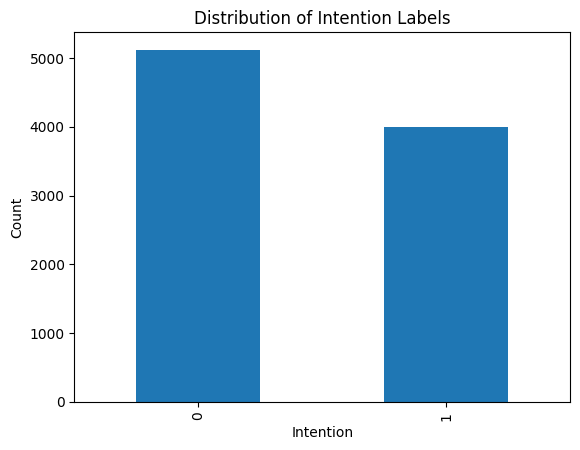

In [14]:
df['intention'].value_counts().plot(kind='bar')
plt.title('Distribution of Intention Labels')
plt.xlabel('Intention')
plt.ylabel('Count')
plt.show()

## Data Preprocessing

In [15]:
stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

In [16]:
def convert_emoji_to_text(text):
    """This function would replace emojies with a space"""
    return emoji.demojize(text)

In [17]:
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [18]:
def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """

    #lowercase the text
    text = text.lower()

    #remove punctuation
    text = re.sub(r'[^\w\s@#]', '', text)   ##text = text.translate(str.maketrans('', '', string.punctuation))

    #remove numbers
    text = re.sub(r'\d+', '', text)

    #remove urls,
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    #remove usernames
    text = re.sub(r'@\w+', '', text)

    #remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    #convert emojis to text
    text = convert_emoji_to_text(text)

    #remove non-word characters
    text = re.sub(r'\W', ' ', text)

    #lemmatization and tokenization of the text
    tokens = word_tokenize(text)

    pos_tags = nltk.pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word, nltk_pos_tagger(tag)) for word, tag in pos_tags]

    #remove stopwords
    tokens = [word for word in tokens if word not in stopwords]

    return tokens


In [19]:
## TODO: Show some samples before/after preprocessing
text =  "Hi!!   😊  @f102m  https://www.bing.com/ #AI"
preprocess_data(text)

['hi', 'ai']

### 1. Briefly explain the advantages and disadvantages of converting the text to lowercase format and tell why we do this in the processing?

#### Advantages:
1. **Simplification**:
   - **Consistency**: Converting text to lowercase ensures that words like "Apple" and "apple" are treated as the same word, reducing variability and making the text more uniform.
   
2. **Improved Model Performance**:
   - **Reduced Vocabulary Size**: By treating different capitalizations as the same word, the overall number of unique words (vocabulary size) decreases, which can improve the efficiency and performance of NLP models.

3. **Enhanced Accuracy**:
   - **Less Noise**: Models can focus on the actual content rather than being distracted by case differences, leading to more accurate text analysis and classification.

#### Disadvantages:
1. **Loss of Information**:
   - **Proper Nouns and Acronyms**: Capitalization can carry important information, such as proper nouns (e.g., "London" vs. "london") or acronyms (e.g., "NASA" vs. "nasa"). Lowercasing removes this distinction.

2. **Contextual Meaning**:
   - **Case-Sensitive Contexts**: In some contexts, the case of letters may change the meaning of words or sentences. For instance, "US" (United States) versus "us" (pronoun).

#### Why We Do This in Processing:
- **Uniformity**: Converting text to lowercase creates uniformity, making it easier to process and analyze text data.
- **Efficiency**: It reduces the complexity of text data, allowing NLP models to learn patterns more effectively.
- **Standard Practice**: It's a common preprocessing step in NLP to ensure that case differences do not affect the analysis, particularly in tasks like sentiment analysis, text classification, and information retrieval.

Overall, lowercasing is a trade-off between losing some specific information and gaining a more streamlined, manageable, and often more accurate dataset for NLP tasks.

### 2. Research the elimination of numbers in the above processes and name the advantages and disadvantages of this process.

#### Advantages:

1. **Noise Reduction**:
   - **Cleaner Data**: Removing numbers can eliminate irrelevant noise, especially if the numbers do not contribute meaningful information to the analysis. This is particularly useful in tasks where numbers are not necessary for understanding the text, such as sentiment analysis or topic modeling.

2. **Dimensionality Reduction**:
   - **Simplified Models**: By eliminating numbers, the dimensionality of the dataset can be reduced, making it easier for NLP models to process and understand the data. This can lead to more efficient training and improved model performance.

3. **Focus on Relevant Features**:
   - **Enhanced Feature Extraction**: Removing numbers allows the model to focus on the more relevant textual features without being distracted by numerical data that might not be relevant to the task at hand.

#### Disadvantages:

1. **Loss of Information**:
   - **Quantitative Data Removal**: Numbers can carry important information, such as quantities, dates, or identifiers. Removing them can lead to a loss of valuable context and potentially affect the accuracy of the analysis, especially in tasks where numerical information is critical.

2. **Impact on Specific Contexts**:
   - **Contextual Relevance**: In some contexts, numbers are essential for understanding the text (e.g., financial reports, scientific data). Removing numbers in such cases can distort the meaning and lead to incorrect interpretations.

#### Why We Perform This Processing:

Removing numbers is typically done to streamline the text data, reducing noise and focusing the model on the most important textual features. This preprocessing step can be particularly beneficial in general text classification, sentiment analysis, and other NLP tasks where numerical data is not crucial to understanding the content. However, it’s important to consider the specific requirements of the task and the potential value that numerical information might bring to the analysis. Adjusting preprocessing steps to the nature of the text and the goals of the analysis ensures that important information is retained while unnecessary noise is minimized.

### 3. We have the ability to use hashtags in the Twitter social network. Explain why we did not remove these expressions and what effect does keeping them have on the performance of the model?

#### Importance of Hashtags

1. **Contextual Information**:
   - **Semantic Meaning**: Hashtags often contain key information about the topic, sentiment, or context of a tweet. For example, hashtags like `#MentalHealth` or `#Happy` can provide valuable insights into the subject matter or the emotional tone of the tweet.

2. **Categorization**:
   - **Topic Identification**: Hashtags are used to categorize tweets, making it easier to identify the main themes or topics discussed. This can help in tasks such as topic modeling or clustering, where understanding the main themes is crucial.

3. **Trend Analysis**:
   - **Popularity and Trends**: Hashtags can indicate trending topics, which are essential for real-time analysis and understanding public opinion. By keeping hashtags, models can better capture these trends and provide more relevant insights.

#### Impact on Model Performance

1. **Enhanced Feature Set**:
   - **Additional Features**: Including hashtags adds to the feature set of the text, providing additional context that can improve the accuracy of text classification models. Hashtags often summarize the key point of the tweet, offering concise and relevant information for the model.

2. **Improved Sentiment Analysis**:
   - **Sentiment Indicators**: Hashtags can be strong indicators of sentiment. For instance, `#Love` or `#Sad` directly convey emotions that can enhance the performance of sentiment analysis models by providing clear sentiment signals.

3. **Contextual Clarity**:
   - **Disambiguation**: Hashtags can help disambiguate the meaning of words that might be unclear in isolation. For example, a tweet containing `#Apple` can clarify whether the tweet is about the fruit or the tech company.


Keeping hashtags in tweets is beneficial because they carry significant contextual, categorical, and trend-related information. This additional data helps improve the performance of NLP models by providing more features for analysis, enhancing sentiment detection, and aiding in topic identification. Therefore, hashtags are a valuable component in the preprocessing of tweet data and should be preserved to maximize the effectiveness of text-based machine learning models.

### 4. Apply the preprocessing function to a few sample tweets and compare before and after.

In [20]:
df['tokens'] = df['tweet'].apply(preprocess_data)
df['token_count'] = df['tokens'].apply(len)
df.head(10)

,tweet,intention,tokens,token_count
0,my life is meaningless i just want to end my l...,1,"[life, meaningless, want, end, life, badly, li...",42
1,muttering i wanna die to myself daily for a fe...,1,"[mutter, wan, na, die, daily, month, feel, wor...",22
2,work slave i really feel like my only purpose ...,1,"[work, slave, really, feel, like, purpose, lif...",32
3,i did something on the 2 of october i overdose...,1,"[something, october, overdose, felt, alone, ho...",29
4,i feel like no one cares i just want to die ma...,1,"[feel, like, one, care, want, die, maybe, feel...",10
5,i am great and wonderful i am worth it except ...,1,"[great, wonderful, worth, except, enough, anyo...",43
6,i ll be dead just you wait and see my last wor...,1,"[dead, wait, see, last, word, death, whoever, ...",20
7,health anxiety prompting some bad thoughts in ...,1,"[health, anxiety, prompt, bad, thought, head, ...",53
8,everything is okay but nothing feels okay i ve...,1,"[everything, okay, nothing, feel, okay, always...",76
9,ptsd and alcohol i had some extremely horrible...,1,"[ptsd, alcohol, extremely, horrible, violent, ...",98


### 5.1 Analyze the token lengths of the cleaned tweets.


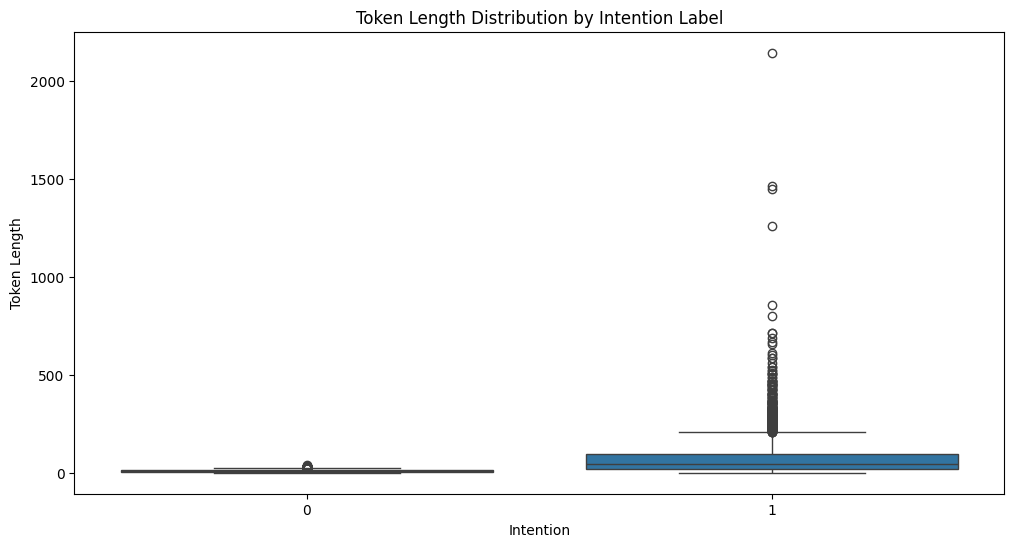

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='intention', y='token_count', data=df)
plt.title('Token Length Distribution by Intention Label')
plt.xlabel('Intention')
plt.ylabel('Token Length')
plt.show()

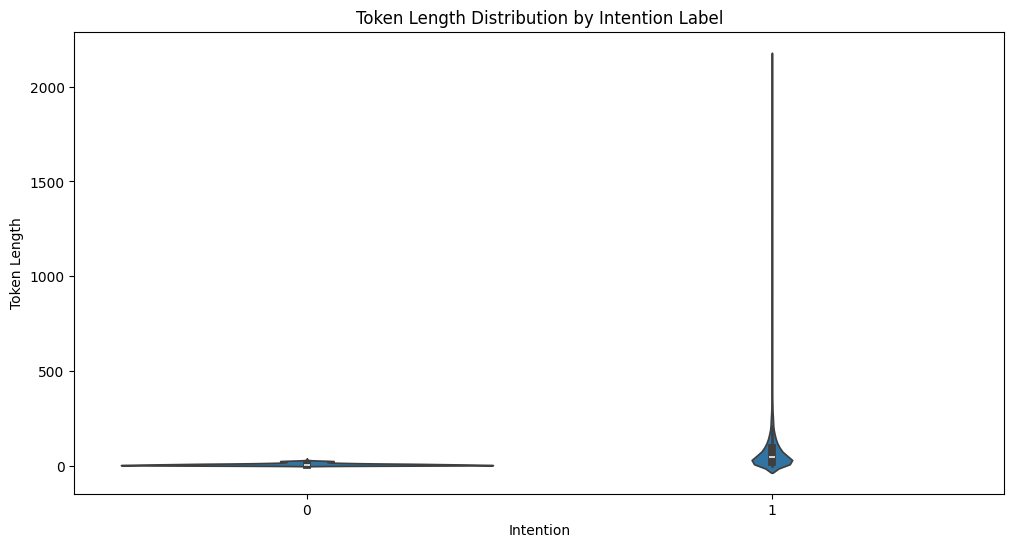

In [22]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='intention', y='token_count', data=df)
plt.title('Token Length Distribution by Intention Label')
plt.xlabel('Intention')
plt.ylabel('Token Length')
plt.show()

### 5.2. Print the statistical summary of token lengths for each intention label and overall dataset.

In [23]:
df['token_count'].describe()

count    9119.000000
mean       37.325145
std        71.783687
min         0.000000
25%         6.000000
50%        12.000000
75%        37.000000
max      2142.000000
Name: token_count, dtype: float64

In [24]:
df.groupby('intention')['token_count'].describe()

,count,mean,std,min,25%,50%,75%,max
intention,,,,,,,,
0,5121.0,8.968756,6.465216,0.0,4.0,7.0,12.0,38.0
1,3998.0,73.646573,96.703284,1.0,19.0,46.0,95.0,2142.0


### Token Frequency Analysis:

In [25]:
def warm_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({random.randint(0, 50)}, 100%, 50%)"  # red to yellow range

def cold_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({random.randint(180, 255)}, 100%, 50%)"  # green to blue range

tweets_label_0 = df[df['intention'] == 0]['tokens'].astype(str).str.cat(sep=' ')
tweets_label_1 = df[df['intention'] == 1]['tokens'].astype(str).str.cat(sep=' ')

wordcloud_0 = WordCloud(width=800, height=400, background_color='white', color_func=cold_color_func).generate(tweets_label_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white', color_func=warm_color_func).generate(tweets_label_1)


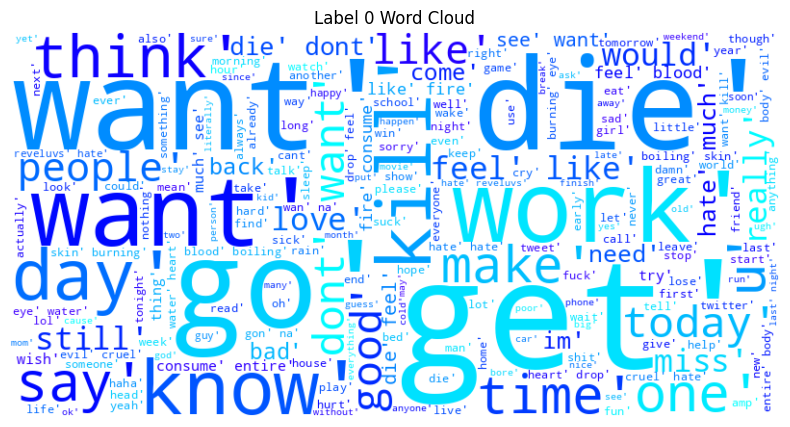

In [26]:
plt.figure(figsize=(10, 5))

plt.plot(1, 2, 1)
plt.title('Label 0 Word Cloud')
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')


plt.show()

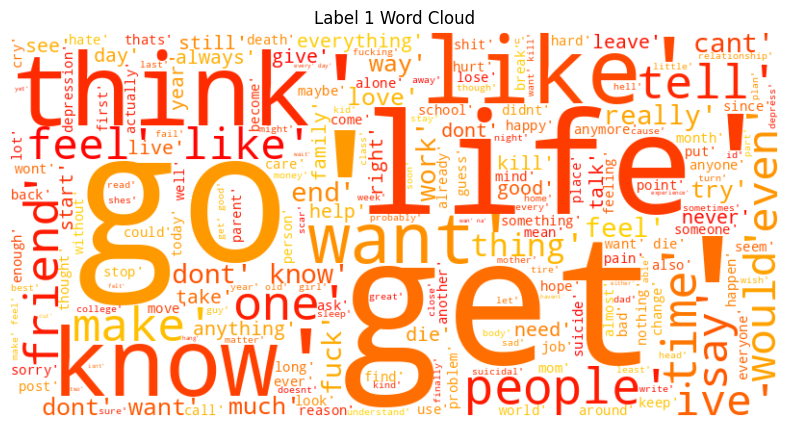

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(1, 2, 2)
plt.title('Label 1 Word Cloud')
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')

plt.show()

# Word2Vec - Word Embedding

In [28]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [29]:
W2V_PATH = None # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2vec model is downloaded.


In [30]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

# Dataset

In [31]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe.copy()
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")
        print(self.dataframe[self.df_token_col])
        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.Tensor:
        vectors = []
        for token in tokens:
            if token in self.w2v_model:
                vectors.append(self.w2v_model[token])
            else:
                vectors.append(np.zeros(self.vector_size))
        return torch.tensor(vectors, dtype=torch.float32)


    def _pad(self, tokens: list):
        if len(tokens) < self.max_sequence_len:
            padding = [''] * (self.max_sequence_len - len(tokens))
            padded_tokens = tokens + padding
        else:
            padded_tokens = tokens[:self.max_sequence_len]
        return padded_tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

In [32]:
dataset = Twitter(df, w2v_model, SEQUENCE_LEN)


Deleted 0-Len Samples: 31
0       [life, meaningless, want, end, life, badly, li...
1       [mutter, wan, na, die, daily, month, feel, wor...
2       [work, slave, really, feel, like, purpose, lif...
3       [something, october, overdose, felt, alone, ho...
4       [feel, like, one, care, want, die, maybe, feel...
                              ...                        
9083    [ever, lay, bed, night, cry, good, enough, cou...
9084    [fault, blame, pain, still, alone, inside, bro...
9085    [stop, ask, trust, still, cough, water, last, ...
9086    [never, know, handle, sadness, cry, make, feel...
9087    [cancer, take, life, blame, cancer, depression...
Name: tokens, Length: 9088, dtype: object


<ipython-input-31-221c59272fd5>:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(vectors, dtype=torch.float32)


In [33]:
dataset.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[15876 
:::::All Valid Tokens:::[10646 
:::::Valid Tokens:::[67.06%]


### 6. Explain what are the methods of dealing with non-existent words in the mentioned dictionary and name the advantages and disadvantages of each.

When dealing with non-existent words in a dictionary (such as a word embedding dictionary like Word2Vec or GloVe), several methods can be employed to handle these out-of-vocabulary (OOV) words. Each method has its advantages and disadvantages. Here are some common strategies:

#### 1. Using a Default Vector
**Method:**
- Assign a default vector (e.g., a zero vector or a random vector) to any OOV word.

**Advantages:**
- **Simplicity:** Easy to implement and requires minimal additional processing.
- **Consistency:** Ensures that every word has a representation, avoiding issues with missing data.

**Disadvantages:**
- **Loss of Information:** Default vectors do not capture any semantic information about the OOV words, which can reduce the model's accuracy.
- **Homogeneity:** Treats all OOV words the same, regardless of their potential different meanings or contexts.

#### 2. Using Subword Information (Character-level Models)
**Method:**
- Break down OOV words into smaller subword units (e.g., characters or n-grams) and create embeddings based on these subword units.

**Advantages:**
- **Better Generalization:** Can provide meaningful representations for OOV words based on their subword components.
- **Robustness to Typos and Morphology:** Can handle variations of words, such as typos or different morphological forms (e.g., plurals, conjugations).

**Disadvantages:**
- **Increased Complexity:** More complex to implement and computationally intensive.
- **Resource Intensive:** Requires additional resources for training and inference.

#### 3. Retraining the Model with New Vocabulary
**Method:**
- Periodically retrain the word embedding model with updated corpora that include the new vocabulary.

**Advantages:**
- **Up-to-date Embeddings:** Ensures that the model is continuously updated with the latest vocabulary and language use.
- **Enhanced Representations:** Provides better and more accurate representations for the entire vocabulary, including previously OOV words.

**Disadvantages:**
- **Time-Consuming:** Retraining can be computationally expensive and time-consuming.
- **Requires Continuous Data Collection:** Needs a constant supply of new data to update the vocabulary.

#### 4. Contextual Embeddings (e.g., BERT, ELMo)
**Method:**
- Use models like BERT or ELMo, which generate word embeddings based on the context in which a word appears rather than relying on a fixed dictionary.

**Advantages:**
- **Dynamic Representations:** Generates different embeddings for a word based on its context, handling polysemy (multiple meanings) effectively.
- **Handles OOV Words:** Better equipped to handle OOV words by leveraging the surrounding context.

**Disadvantages:**
- **High Computational Cost:** Requires significant computational resources for training and inference.
- **Complexity:** More complex architecture and implementation compared to static embeddings.

#### 5. Lookup in External Resources
**Method:**
- Use external resources like WordNet, dictionaries, or thesauruses to find synonyms or similar words for the OOV word and use their embeddings.

**Advantages:**
- **Enriches Vocabulary:** Can expand the vocabulary and improve embeddings by leveraging external knowledge.
- **Contextual Similarity:** Provides embeddings that are semantically similar to the OOV word.

**Disadvantages:**
- **Dependency on External Resources:** Requires access to and integration with external resources, which may not always be up-to-date or comprehensive.
- **Potential Inconsistencies:** The quality and consistency of external resources can vary, leading to potential issues in embedding quality.

#### 6. Using Contextual Averaging
**Method:**
- Average the embeddings of the surrounding words to generate a proxy embedding for the OOV word based on its context.

**Advantages:**
- **Context-Aware:** Provides a context-specific embedding for the OOV word, capturing some semantic information from its surroundings.
- **Simple Implementation:** Relatively straightforward to implement compared to more complex models.

**Disadvantages:**
- **Approximation:** The averaged vector is an approximation and may not fully capture the meaning of the OOV word.
- **Context Dependency:** Performance heavily depends on the quality and relevance of the surrounding context.

Each method has its trade-offs between simplicity, computational cost, and the richness of the resulting word representations. The choice of method depends on the specific requirements and constraints of the application at hand.

# Prepare Data

### 7. Briefly explain how the Adam optimizer works and how it differs from the SGD optimizer.

#### Adam Optimizer

The Adam optimizer is a popular optimization algorithm used for training deep neural networks. It combines the benefits of two other methods: AdaGrad and RMSProp. Here's a simple explanation of how it works:

1. **Initialization**:
   - Adam starts by initializing two vectors to keep track of the moving averages of the gradients.

2. **Gradient Calculation**:
   - For each training step, Adam calculates the gradient of the loss function with respect to the model parameters.

3. **Update Moving Averages**:
   - Adam updates two moving averages:
     - The first moving average estimates the mean of the gradients.
     - The second moving average estimates the uncentered variance of the gradients.

4. **Bias Correction**:
   - Adam adjusts these moving averages to correct for their bias towards zero, especially in the initial training steps.

5. **Parameter Update**:
   - The model parameters are then updated using these corrected moving averages. This helps in achieving a more stable and efficient convergence.

#### Differences Between Adam and SGD

##### Stochastic Gradient Descent (SGD)

- **Learning Rate**:
  - SGD uses a fixed learning rate for all parameters. This learning rate needs to be carefully tuned and can significantly affect the training process.

- **Gradient Descent**:
  - SGD updates the model parameters by moving them in the direction of the negative gradient. This direction is determined by the current batch of training data.

- **Simplicity**:
  - SGD is simple and easy to implement but can struggle with noisy data and may converge slowly.

###### Adam

- **Adaptive Learning Rates**:
  - Adam adjusts the learning rate for each parameter individually. This means it can adapt the learning rate based on how the gradients change, leading to more efficient training.

- **Combination of Momentum and RMSProp**:
  - Adam uses concepts from both momentum (to smooth out the updates) and RMSProp (to adapt the learning rates), making it robust to noisy gradients and effective for a wide range of problems.

- **Bias Correction**:
  - Adam includes a mechanism to correct for biases in the estimates of the moving averages, especially at the start of training.

##### Summary

- **SGD** is straightforward and works well for many problems, but it requires careful tuning of the learning rate and may struggle with noisy gradients.
- **Adam** provides a more adaptive approach, automatically adjusting learning rates and combining the strengths of momentum and RMSProp, making it well-suited for complex and noisy problems.

### 8. Use the Cross Entropy cost function. Also, tell the reason for using this cost function according to the nature of the problem.

#### Cross Entropy Cost Function

The Cross Entropy cost function, often used in classification problems, measures the performance of a classification model whose output is a probability value between 0 and 1. Here's a brief explanation of why it is used and how it aligns with the nature of classification problems:

#### What is Cross Entropy?

Cross Entropy is a measure of the difference between two probability distributions for a given set of events. In the context of neural networks, it is used to measure the performance of a classification model by comparing the predicted probability distribution (outputs) with the true distribution (actual labels).

#### Why Use Cross Entropy for Classification?

1. **Probabilistic Interpretation**:
   - Cross Entropy cost function directly aligns with the probabilistic interpretation of the model’s output. It measures how well the predicted probabilities match the true class labels.

2. **Gradient Behavior**:
   - The Cross Entropy cost function has a smooth gradient, which helps in efficient learning and convergence. It provides a strong signal when the prediction is far from the true label and a smaller signal as it gets closer, leading to more stable and faster convergence.

3. **Penalizing Incorrect Predictions**:
   - Cross Entropy penalizes incorrect predictions more heavily than correct ones. This characteristic helps the model to focus more on reducing the probability assigned to incorrect classes and increasing the probability of the correct class.

4. **Class Imbalance**:
   - For imbalanced datasets, Cross Entropy helps the model to still learn effectively. It ensures that the model is penalized according to the actual probability of the class rather than the absolute count of misclassifications.

#### Applicability to the Problem

In classification problems, especially those involving multiple classes (multi-class classification), the objective is to assign the correct class label to each input sample. The output of the model is often a probability distribution over all possible classes. Cross Entropy is particularly suitable for these scenarios because:

- **Alignment with Output**: The nature of classification problems involves predicting class probabilities. Cross Entropy directly measures the deviation between predicted probabilities and actual classes.
- **Effective Learning**: By penalizing incorrect predictions more heavily, it drives the model to focus on getting the probability distribution as close as possible to the true distribution, improving the model’s accuracy.

#### Summary

Using the Cross Entropy cost function in classification problems is effective because it aligns well with the goal of minimizing the difference between predicted and actual probability distributions. It provides an intuitive and mathematically sound way to measure the performance of a classification model, encouraging the model to produce outputs that are closer to the actual class labels.

## Split Data into train-valid

### 9.   Now divide the data into two parts, training and testing. Report the ratio of this division and why you use this ratio.

In machine learning, it is crucial to divide your dataset into training and testing sets to evaluate the performance of your model on unseen data. A common practice is to use a specific ratio for this division.

#### Common Ratios

- **80/20 Split**: 80% of the data is used for training and 20% for testing.
- **70/30 Split**: 70% of the data is used for training and 30% for testing.
- **75/25 Split**: 75% of the data is used for training and 25% for testing.

#### Recommended Ratio

The most common and recommended ratio is the **80/20 split**. This ratio is widely used because it provides a good balance between having enough data to train the model and enough data to test the model's performance.

#### Why Use the 80/20 Ratio?

1. **Sufficient Training Data**:
   - Using 80% of the data for training ensures that the model has a substantial amount of data to learn from. This is especially important for deep learning models that require large amounts of data to perform well.

2. **Adequate Testing Data**:
   - Reserving 20% of the data for testing ensures that there is a significant portion of the data that the model has not seen during training. This helps in effectively evaluating the model's performance and generalization capability.

3. **Balance Between Bias and Variance**:
   - The 80/20 split helps strike a balance between bias and variance. It ensures that the training set is large enough to minimize bias and the testing set is large enough to give an accurate estimate of the model’s variance.

4. **Standard Practice**:
   - The 80/20 split is a standard practice in the machine learning community. It allows for consistent comparison of results across different studies and projects.



In [34]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

## Create Datasets

In [35]:
warnings.filterwarnings("ignore")

train_dataset = Twitter(train_df, w2v_model, sequence_len=SEQUENCE_LEN)
valid_dataset = Twitter(valid_df, w2v_model, sequence_len=SEQUENCE_LEN)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


Deleted 0-Len Samples: 23
0           [feel, like, end, life, worth, live, without]
1       [surprise, meteor, come, fell, oo, want, die, ...
2       [try, help, friend, need, drain, life, note, c...
3       [im, really, worry, mathematics, subject, im, ...
4       [one, year, retirement, hope, enjoy, busy, pen...
                              ...                        
7267                                         [ugh, sorry]
7268    [forgot, duh, always, love, song, always, pers...
7269                                 [know, alpha, stamp]
7270    [lose, never, good, type, shit, amfed, life, w...
7271    [congratulation, take, asia, regional, final, ...
Name: tokens, Length: 7272, dtype: object
Deleted 0-Len Samples: 8
0                                             [die, want]
1       [suicide, rational, choice, hi, anonymous, cro...
2       [invasive, thought, depress, long, timei, amsu...
3        [ok, back, goin, orson, fake, dont, wan, na, go]
4                               [get,

In [36]:
train_dataset.seq_report()
print("_______________________")
valid_dataset.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[13851 
:::::All Valid Tokens:::[ 9548 
:::::Valid Tokens:::[68.93%]
_______________________
Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[ 6207 
:::::All Valid Tokens:::[ 4851 
:::::Valid Tokens:::[78.15%]


# Model and Train

## Utils

In [37]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device = 'auto'):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    model = model.to(device)

    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # use model's forward pass to generate outputs
        outputs = model(inputs.transpose(1, 2))

        # calculate model's loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # calculate/update model's accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(correct_predictions / total_predictions, 5),
        )

    test_loss = test_loss / len(loader)
    test_acc = correct_predictions / total_predictions

    return test_loss, test_acc


In [38]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: str = 'auto'
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        itr = tqdm(train_loader, total=len(train_loader), leave=False)

        for idx, (inputs, labels) in enumerate(itr, start=1):
            # move model's inputs to `device`
            inputs, labels = inputs.to(device), labels.to(device)

            # use model's forward pass to generate outputs
            outputs = model(inputs.transpose(1, 2))

            # process model's predictipns and calculate/update accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_acc = correct / total

            # calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item()

            # clear optimizer's state and zero previous grads
            optimizer.zero_grad()

            # backward calculated loss
            loss.backward()

            # step optimizer
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
                loss=round(loss.item(), 5),
                accuracy=round(epoch_acc, 5),
            )

        epoch_loss = (epoch_loss / len(train_loader) )
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
        )

        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        print(f"Epoch {epoch + 1} :")
        print(f"train_loss = {epoch_loss :.6f}, train_acc = {epoch_acc:.6f}, valid_loss =  {valid_loss:.6f}, valid_acc = {valid_acc:.6f}")
        print(40 * "_")

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "valid_loss": valid_losses,
        "valid_acc": valid_accs,
    }
    return history


In [39]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [40]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    labels = []
    predicted = []

    for inputs, targets in itr:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs.transpose(1, 2))
        _, preds = torch.max(outputs, 1)

        labels.extend(targets.cpu().numpy())
        predicted.extend(preds.cpu().numpy())

    labels = np.array(labels)
    predicted = np.array(predicted)

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f")
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [41]:
class CNN(nn.Module):
    def __init__(self, input_size = 300, sequence_len_1_ = 64, sequence_len_2_ = 128, output_size = 2, flatt_size = 12288):
        super(CNN, self).__init__()
        self.conv1_1 = nn.Conv1d(input_size, sequence_len_1, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv1d(input_size, sequence_len_1, kernel_size=5, padding=2)
        self.conv1_3 = nn.Conv1d(input_size, sequence_len_1, kernel_size=7, padding=3)

        self.conv2_1 = nn.Conv1d(sequence_len_1, sequence_len_2, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv1d(sequence_len_1, sequence_len_2, kernel_size=5, padding=2)
        self.conv2_3 = nn.Conv1d(sequence_len_1, sequence_len_2, kernel_size=7, padding=3)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(flatt_size, sequence_len_2)
        self.fc2 = nn.Linear(sequence_len_2, output_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.conv1_1(x))
        x2 = self.relu(self.conv1_2(x))
        x3 = self.relu(self.conv1_3(x))

        x1 = self.pool(self.relu(self.conv2_1(x1)))
        x2 = self.pool(self.relu(self.conv2_2(x2)))
        x3 = self.pool(self.relu(self.conv2_3(x3)))

        x_concatenated = torch.cat((x1, x2, x3), dim=1)

        x = x_concatenated.view(x_concatenated.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

### 10. What is the effect of kernel size in convolution layers and how is it effective in extracting input features? What does it mean to be more or less?

In convolutional neural networks (CNNs), the kernel size (or filter size) in convolution layers is a critical hyperparameter that directly impacts how the network extracts features from the input data. The kernel size determines the dimensions of the filter that slides over the input to produce feature maps.

##### Effects of Kernel Size

1. **Small Kernel Size *:*
   - **Fine Details**: Small kernels capture fine-grained details and local patterns in the input data.
   - **Less Computationally Expensive**: Smaller filters require fewer computations, making the network faster and less resource-intensive.
   - **Stacking Layers**: Using smaller kernels allows stacking more convolutional layers, enabling the network to learn hierarchical features..

2. **Large Kernel Size **:
   - **Broader Context**: Larger kernels capture more global patterns and broader context from the input data.
   - **More Computationally Expensive**: Larger filters increase the computational load and memory usage.
   - **Potential Overfitting**: With fewer layers, larger kernels might lead to overfitting as they capture more complex patterns directly.

#### Choosing Kernel Size

- **Nature of the Data**:
  - For images with fine details (e.g., textures, edges), smaller kernels are effective.
  - For images requiring broader context (e.g., large objects or patterns), larger kernels might be beneficial.

- **Network Architecture**:
  - Modern architectures often use small kernels and increase the network's depth to capture hierarchical features.
  - In some architectures, a combination of small and large kernels is used to balance local and global feature extraction.



### 11. In your opinion, why didn't we reduce the convolution output and did this reduction through Feed Forward layers and what advantages can this layer have over alternative methods? Investigate the reason for this and state the results.

#### Reasons for Not Reducing Convolution Output Explicitly:

1. **Preserving Spatial Information**:
   - Convolutional layers are designed to capture spatial hierarchies and local patterns in the input data, such as edges, textures, and shapes in images. Reducing the dimensionality too early could discard valuable spatial information that is crucial for understanding the input, especially in the early stages of a CNN.

2. **Learning Rich Feature Maps**:
   - Convolutional layers progressively learn more abstract and complex features as the data passes through the network. By maintaining the full dimensionality, the model can capture a richer set of features, which can be crucial for achieving high performance in tasks like image recognition, where detailed information at different scales is important.

3. **Flexibility for Fully Connected Layers**:
   - Fully connected (FC) layers offer flexibility for dimensionality reduction later in the network architecture. This allows for more control over the final feature representation before classification, enabling the model to make more informed and accurate predictions.

#### Advantages of Fully Connected (FC) Layers for Dimensionality Reduction:

1. **Learned Reduction**:
   - FC layers can learn the optimal way to reduce the dimensionality of the features based on the specific task at hand. This learned reduction is often more effective than pre-defined methods such as pooling layers (e.g., max pooling, average pooling) because it can adapt to the unique characteristics of the dataset.

2. **Non-linear Activation**:
   - FC layers can be combined with non-linear activation functions (e.g., ReLU) to introduce non-linearity before dimensionality reduction. This allows the model to learn complex feature representations that simple pooling operations might not capture, enhancing the model’s ability to differentiate between classes.

3. **Adaptability**:
   - FC layers provide greater control over the final feature representation. Researchers and practitioners can experiment with different numbers of neurons in the FC layers to achieve the desired level of dimensionality reduction while maintaining good performance. This adaptability is particularly useful when fine-tuning the model for specific tasks or datasets.

#### Investigation and Results

To investigate the impact of not reducing the convolution output early and relying on FC layers for dimensionality reduction, we can look at the performance and architecture of several successful CNN models:

1. **VGG Network**:
   - In the VGG architecture, a series of convolutional layers are used to extract features, followed by three fully connected layers for the final classification. The convolutional layers maintain spatial dimensions until the final layers, ensuring rich feature extraction. The FC layers then reduce the dimensionality for the classification task, contributing to the model’s high accuracy on image recognition tasks.

2. **ResNet (Residual Networks)**:
   - ResNet uses skip connections to create very deep networks while avoiding the vanishing gradient problem. The convolutional layers are responsible for feature extraction, and the final few layers are fully connected layers that reduce the dimensionality for classification. This architecture has achieved state-of-the-art performance on various benchmarks by leveraging the strengths of both convolutional and fully connected layers.

3. **Inception Networks**:
   - Inception networks use multiple kernel sizes in parallel to capture features at different scales. The output from these convolutional layers is concatenated and then passed through fully connected layers for dimensionality reduction and classification. This approach demonstrates the effectiveness of maintaining convolutional output dimensions until the final layers.



## Training

### 12. How do different batch sizes and learning rates affect the training performance and generalization of a Convolutional Neural Network (CNN) model on our specific dataset, and what are the optimal values for these hyperparameters based on our observed training and validation metrics?

#### Effects of Batch Size

1. **Smaller Batch Size**:
   - **Noisy Gradient Estimates**: Smaller batch sizes produce noisier gradient estimates. This noise can help in escaping local minimum, potentially leading to better generalization, but can also cause more fluctuation in the loss during training.
   - **Faster Updates**: Each epoch processes more updates, which can lead to faster convergence in terms of epochs but might require more overall computation.
   - **Memory Efficiency**: Smaller batches require less memory, making it possible to train larger models on hardware with limited memory.

2. **Larger Batch Size**:
   - **Smoother Gradient Estimates**: Larger batches provide more accurate estimates of the gradient, leading to smoother convergence curves. However, this might also cause the model to get stuck in sharp local minimum.
   - **Slower Updates**: Each epoch processes fewer updates, which can slow down the convergence in terms of epochs but often requires fewer epochs to converge.
   - **Better Parallelism**: Larger batches can take better advantage of modern hardware (like GPUs), potentially speeding up the wall-clock time per epoch.

#### Effects of Learning Rate

1. **Lower Learning Rate**:
   - **Slow Convergence**: Smaller learning rates lead to more gradual updates of the model parameters, often resulting in slower convergence. This can be beneficial for fine-tuning and avoiding overshooting minimum.
   - **More Precise**: Can achieve more precise minimum, but if too low, might get stuck in a local minimum or take an impractically long time to converge.

2. **Higher Learning Rate**:
   - **Faster Convergence**: Larger learning rates can accelerate convergence, especially in the initial stages. However, they might cause the model to overshoot minimum or diverge if too high.
   - **Potential Instability**: Too high learning rates can lead to unstable training, with the loss fluctuating or even increasing.




### 1:



In [42]:
input_size = 300
output_size = 2
sequence_len_1 = 64
sequence_len_2 = 128
loss_function = nn.CrossEntropyLoss()

EPOCHS = 15
LEARNING_RATE_1 = 0.0004
BATCH_SIZE_1 = 64
LEARNING_RATE_2 = 0.0004
BATCH_SIZE_2 = 128
LEARNING_RATE_3 = 0.001
BATCH_SIZE_3 = 64

#### 1:
LEARNING_RATE_1 = 0.0004   
BATCH_SIZE_1 = 64  

In [43]:
train_dataset = Twitter(train_df, w2v_model, sequence_len_1)
valid_dataset = Twitter(valid_df, w2v_model, sequence_len_1)

Deleted 0-Len Samples: 23
0           [feel, like, end, life, worth, live, without]
1       [surprise, meteor, come, fell, oo, want, die, ...
2       [try, help, friend, need, drain, life, note, c...
3       [im, really, worry, mathematics, subject, im, ...
4       [one, year, retirement, hope, enjoy, busy, pen...
                              ...                        
7267                                         [ugh, sorry]
7268    [forgot, duh, always, love, song, always, pers...
7269                                 [know, alpha, stamp]
7270    [lose, never, good, type, shit, amfed, life, w...
7271    [congratulation, take, asia, regional, final, ...
Name: tokens, Length: 7272, dtype: object
Deleted 0-Len Samples: 8
0                                             [die, want]
1       [suicide, rational, choice, hi, anonymous, cro...
2       [invasive, thought, depress, long, timei, amsu...
3        [ok, back, goin, orson, fake, dont, wan, na, go]
4                               [get,

In [44]:
cnn_model = CNN(input_size,sequence_len_1, sequence_len_2, output_size, int(3 * sequence_len_1 * sequence_len_2 * 0.5))
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE_1)

In [45]:
cnn_model_train_history = train_model(
    model=cnn_model,
    batch_size=BATCH_SIZE_1,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device='auto'
)

Epoch 1 :
train_loss = 0.324082, train_acc = 0.860286, valid_loss =  0.232736, valid_acc = 0.899229
________________________________________


Epoch 2 :
train_loss = 0.204382, train_acc = 0.913641, valid_loss =  0.212715, valid_acc = 0.912445
________________________________________


Epoch 3 :
train_loss = 0.144909, train_acc = 0.941832, valid_loss =  0.220392, valid_acc = 0.914097
________________________________________


Epoch 4 :
train_loss = 0.085460, train_acc = 0.969472, valid_loss =  0.271917, valid_acc = 0.900330
________________________________________


Epoch 5 :
train_loss = 0.040919, train_acc = 0.987074, valid_loss =  0.319840, valid_acc = 0.911894
________________________________________


Epoch 6 :
train_loss = 0.023930, train_acc = 0.992574, valid_loss =  0.345137, valid_acc = 0.908040
________________________________________


Epoch 7 :
train_loss = 0.022180, train_acc = 0.992987, valid_loss =  0.357546, valid_acc = 0.908590
________________________________________


Epoch 8 :
train_loss = 0.012386, train_acc = 0.995462, valid_loss =  0.415387, valid_acc = 0.908040
________________________________________


Epoch 9 :
train_loss = 0.007695, train_acc = 0.996700, valid_loss =  0.431587, valid_acc = 0.916300
________________________________________


Epoch 10 :
train_loss = 0.007193, train_acc = 0.997250, valid_loss =  0.451586, valid_acc = 0.914097
________________________________________


Epoch 11 :
train_loss = 0.007441, train_acc = 0.997250, valid_loss =  0.442040, valid_acc = 0.914648
________________________________________


Epoch 12 :
train_loss = 0.006386, train_acc = 0.997112, valid_loss =  0.480787, valid_acc = 0.919053
________________________________________


Epoch 13 :
train_loss = 0.007221, train_acc = 0.997250, valid_loss =  0.455246, valid_acc = 0.913546
________________________________________


Epoch 14 :
train_loss = 0.006201, train_acc = 0.996837, valid_loss =  0.482322, valid_acc = 0.917401
________________________________________


Epoch 15 :
train_loss = 0.007994, train_acc = 0.997525, valid_loss =  0.458121, valid_acc = 0.912445
________________________________________


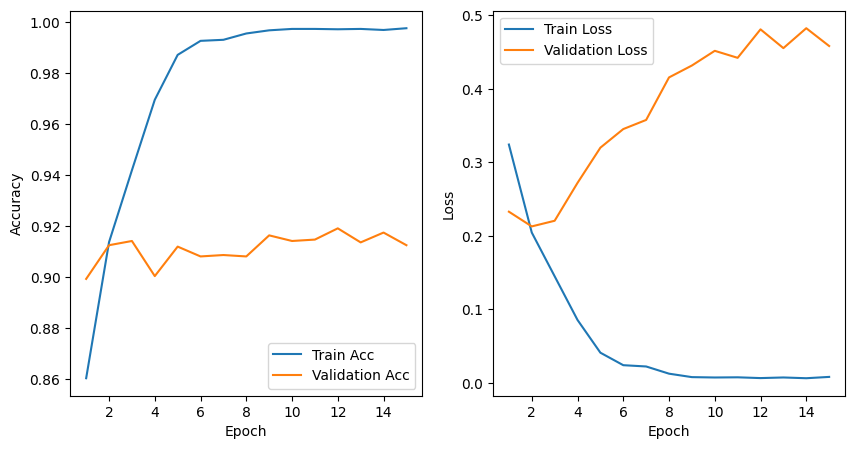

In [46]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

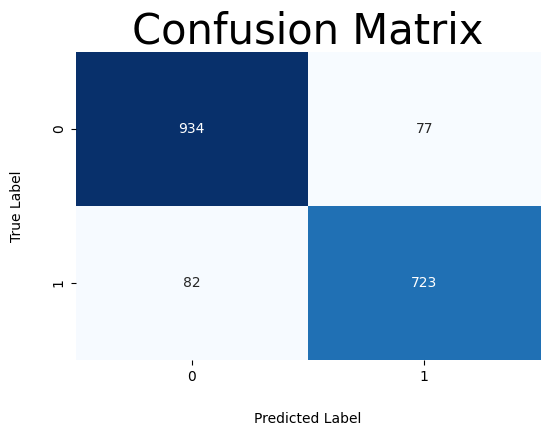

In [47]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [48]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.911
F1:        0.911
Precision: 0.912
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1011
           1       0.90      0.90      0.90       805

    accuracy                           0.91      1816
   macro avg       0.91      0.91      0.91      1816
weighted avg       0.91      0.91      0.91      1816



#### 2:
LEARNING_RATE_2 = 0.0004  
BATCH_SIZE_2 = 128

In [49]:
train_dataset = Twitter(train_df, w2v_model, sequence_len_1)
valid_dataset = Twitter(valid_df, w2v_model, sequence_len_1)

Deleted 0-Len Samples: 23
0           [feel, like, end, life, worth, live, without]
1       [surprise, meteor, come, fell, oo, want, die, ...
2       [try, help, friend, need, drain, life, note, c...
3       [im, really, worry, mathematics, subject, im, ...
4       [one, year, retirement, hope, enjoy, busy, pen...
                              ...                        
7267                                         [ugh, sorry]
7268    [forgot, duh, always, love, song, always, pers...
7269                                 [know, alpha, stamp]
7270    [lose, never, good, type, shit, amfed, life, w...
7271    [congratulation, take, asia, regional, final, ...
Name: tokens, Length: 7272, dtype: object
Deleted 0-Len Samples: 8
0                                             [die, want]
1       [suicide, rational, choice, hi, anonymous, cro...
2       [invasive, thought, depress, long, timei, amsu...
3        [ok, back, goin, orson, fake, dont, wan, na, go]
4                               [get,

In [50]:
cnn_model = CNN(input_size,sequence_len_1, sequence_len_2, output_size, int(3 * sequence_len_1 * sequence_len_2 * 0.5))
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE_2)

In [51]:
cnn_model_train_history = train_model(
    model=cnn_model,
    batch_size=BATCH_SIZE_2,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device='auto'
)

Epoch 1 :
train_loss = 0.362601, train_acc = 0.835946, valid_loss =  0.264584, valid_acc = 0.889868
________________________________________


Epoch 2 :
train_loss = 0.237389, train_acc = 0.897552, valid_loss =  0.221322, valid_acc = 0.908040
________________________________________


Epoch 3 :
train_loss = 0.179952, train_acc = 0.925330, valid_loss =  0.203793, valid_acc = 0.921256
________________________________________


Epoch 4 :
train_loss = 0.144748, train_acc = 0.942244, valid_loss =  0.206640, valid_acc = 0.903084
________________________________________


Epoch 5 :
train_loss = 0.100176, train_acc = 0.963696, valid_loss =  0.217792, valid_acc = 0.912996
________________________________________


Epoch 6 :
train_loss = 0.057318, train_acc = 0.980198, valid_loss =  0.252188, valid_acc = 0.905286
________________________________________


Epoch 7 :
train_loss = 0.028485, train_acc = 0.991612, valid_loss =  0.288646, valid_acc = 0.922907
________________________________________


Epoch 8 :
train_loss = 0.017290, train_acc = 0.995050, valid_loss =  0.334328, valid_acc = 0.917952
________________________________________


Epoch 9 :
train_loss = 0.010613, train_acc = 0.997387, valid_loss =  0.399428, valid_acc = 0.914648
________________________________________


Epoch 10 :
train_loss = 0.010338, train_acc = 0.996975, valid_loss =  0.394413, valid_acc = 0.912445
________________________________________


Epoch 11 :
train_loss = 0.008539, train_acc = 0.996287, valid_loss =  0.470190, valid_acc = 0.901982
________________________________________


Epoch 12 :
train_loss = 0.018567, train_acc = 0.992712, valid_loss =  0.421981, valid_acc = 0.919604
________________________________________


Epoch 13 :
train_loss = 0.013431, train_acc = 0.996287, valid_loss =  0.431405, valid_acc = 0.904185
________________________________________


Epoch 14 :
train_loss = 0.008672, train_acc = 0.997250, valid_loss =  0.455329, valid_acc = 0.908040
________________________________________


Epoch 15 :
train_loss = 0.007456, train_acc = 0.997387, valid_loss =  0.455382, valid_acc = 0.900881
________________________________________


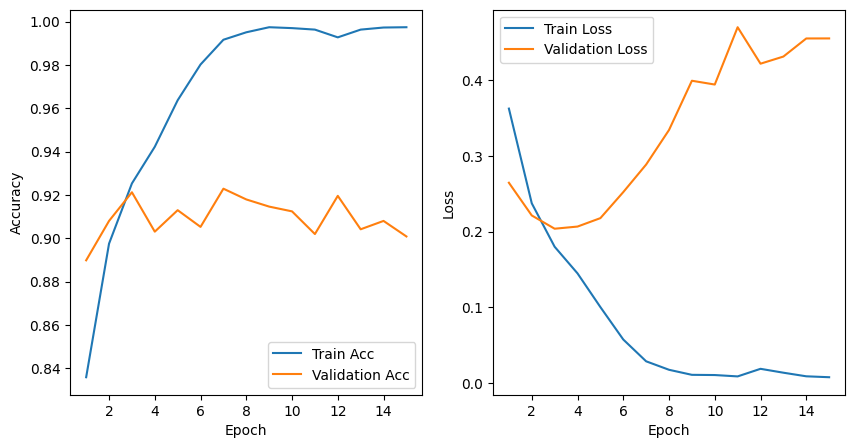

In [52]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

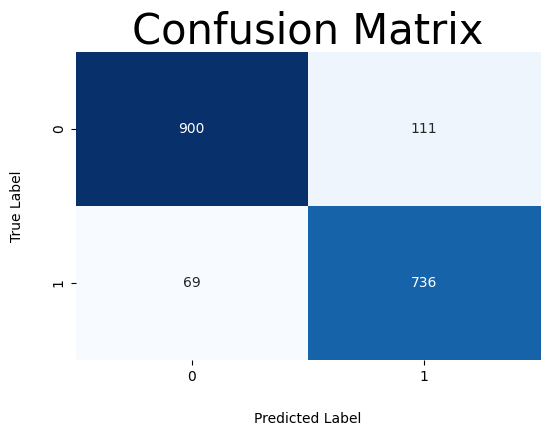

In [53]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [54]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.902
F1:        0.900
Precision: 0.899
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1011
           1       0.87      0.91      0.89       805

    accuracy                           0.90      1816
   macro avg       0.90      0.90      0.90      1816
weighted avg       0.90      0.90      0.90      1816



#### 3:
LEARNING_RATE_3 = 0.001   
BATCH_SIZE_3 = 64

In [55]:
train_dataset = Twitter(train_df, w2v_model, sequence_len_1)
valid_dataset = Twitter(valid_df, w2v_model, sequence_len_1)

Deleted 0-Len Samples: 23
0           [feel, like, end, life, worth, live, without]
1       [surprise, meteor, come, fell, oo, want, die, ...
2       [try, help, friend, need, drain, life, note, c...
3       [im, really, worry, mathematics, subject, im, ...
4       [one, year, retirement, hope, enjoy, busy, pen...
                              ...                        
7267                                         [ugh, sorry]
7268    [forgot, duh, always, love, song, always, pers...
7269                                 [know, alpha, stamp]
7270    [lose, never, good, type, shit, amfed, life, w...
7271    [congratulation, take, asia, regional, final, ...
Name: tokens, Length: 7272, dtype: object
Deleted 0-Len Samples: 8
0                                             [die, want]
1       [suicide, rational, choice, hi, anonymous, cro...
2       [invasive, thought, depress, long, timei, amsu...
3        [ok, back, goin, orson, fake, dont, wan, na, go]
4                               [get,

In [56]:
cnn_model = CNN(input_size,sequence_len_1, sequence_len_2, output_size, int(3 * sequence_len_1 * sequence_len_2 * 0.5))
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE_3)

In [57]:
cnn_model_train_history = train_model(
    model=cnn_model,
    batch_size=BATCH_SIZE_3,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device='auto'
)

Epoch 1 :
train_loss = 0.292104, train_acc = 0.876100, valid_loss =  0.217578, valid_acc = 0.910793
________________________________________


Epoch 2 :
train_loss = 0.182664, train_acc = 0.925330, valid_loss =  0.202800, valid_acc = 0.921806
________________________________________


Epoch 3 :
train_loss = 0.111208, train_acc = 0.958196, valid_loss =  0.219920, valid_acc = 0.914648
________________________________________


Epoch 4 :
train_loss = 0.056239, train_acc = 0.978548, valid_loss =  0.341464, valid_acc = 0.905837
________________________________________


Epoch 5 :
train_loss = 0.046253, train_acc = 0.983361, valid_loss =  0.317478, valid_acc = 0.906938
________________________________________


Epoch 6 :
train_loss = 0.022797, train_acc = 0.991337, valid_loss =  0.431030, valid_acc = 0.916850
________________________________________


Epoch 7 :
train_loss = 0.011852, train_acc = 0.995875, valid_loss =  0.510889, valid_acc = 0.916850
________________________________________


Epoch 8 :
train_loss = 0.025841, train_acc = 0.991474, valid_loss =  0.411804, valid_acc = 0.906938
________________________________________


Epoch 9 :
train_loss = 0.015827, train_acc = 0.993812, valid_loss =  0.474370, valid_acc = 0.909141
________________________________________


Epoch 10 :
train_loss = 0.009731, train_acc = 0.996562, valid_loss =  0.521192, valid_acc = 0.914648
________________________________________


Epoch 11 :
train_loss = 0.007249, train_acc = 0.997250, valid_loss =  0.510471, valid_acc = 0.910242
________________________________________


Epoch 12 :
train_loss = 0.005377, train_acc = 0.997525, valid_loss =  0.625433, valid_acc = 0.918502
________________________________________


Epoch 13 :
train_loss = 0.006538, train_acc = 0.997525, valid_loss =  0.532107, valid_acc = 0.908590
________________________________________


Epoch 14 :
train_loss = 0.005673, train_acc = 0.998075, valid_loss =  0.572431, valid_acc = 0.916850
________________________________________


Epoch 15 :
train_loss = 0.005149, train_acc = 0.998212, valid_loss =  0.540834, valid_acc = 0.913546
________________________________________


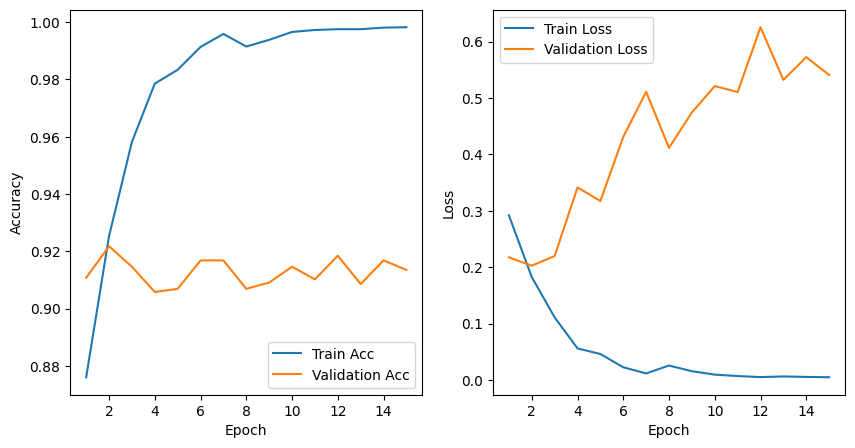

In [58]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

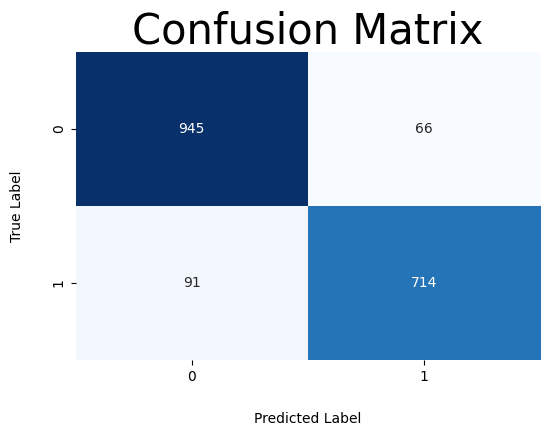

In [59]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [60]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.911
F1:        0.912
Precision: 0.914
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1011
           1       0.92      0.89      0.90       805

    accuracy                           0.91      1816
   macro avg       0.91      0.91      0.91      1816
weighted avg       0.91      0.91      0.91      1816



### Analyzing Our Outputs


### 2: Context Window

In [61]:
input_size = 300
output_size = 2
sequence_len_1 = 196
sequence_len_2 = 196 * 2
loss_function = nn.CrossEntropyLoss()

EPOCHS = 15
LEARNING_RATE_1 = 0.0004
BATCH_SIZE_1 = 64


In [62]:
train_dataset = Twitter(train_df, w2v_model, sequence_len_1)
valid_dataset = Twitter(valid_df, w2v_model, sequence_len_1)

Deleted 0-Len Samples: 23
0           [feel, like, end, life, worth, live, without]
1       [surprise, meteor, come, fell, oo, want, die, ...
2       [try, help, friend, need, drain, life, note, c...
3       [im, really, worry, mathematics, subject, im, ...
4       [one, year, retirement, hope, enjoy, busy, pen...
                              ...                        
7267                                         [ugh, sorry]
7268    [forgot, duh, always, love, song, always, pers...
7269                                 [know, alpha, stamp]
7270    [lose, never, good, type, shit, amfed, life, w...
7271    [congratulation, take, asia, regional, final, ...
Name: tokens, Length: 7272, dtype: object
Deleted 0-Len Samples: 8
0                                             [die, want]
1       [suicide, rational, choice, hi, anonymous, cro...
2       [invasive, thought, depress, long, timei, amsu...
3        [ok, back, goin, orson, fake, dont, wan, na, go]
4                               [get,

In [63]:
cnn_model = CNN(input_size,sequence_len_1, sequence_len_2, output_size, int(3 * sequence_len_1 * sequence_len_2 * 0.5))
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE_1)

In [64]:
cnn_model_train_history = train_model(
    model=cnn_model,
    batch_size=BATCH_SIZE_1,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device='auto'
)

Epoch 1 :
train_loss = 0.369002, train_acc = 0.848322, valid_loss =  0.238078, valid_acc = 0.894824
________________________________________


Epoch 2 :
train_loss = 0.195661, train_acc = 0.913779, valid_loss =  0.194743, valid_acc = 0.917952
________________________________________


Epoch 3 :
train_loss = 0.124830, train_acc = 0.948432, valid_loss =  0.248616, valid_acc = 0.895374
________________________________________


Epoch 4 :
train_loss = 0.050812, train_acc = 0.983361, valid_loss =  0.243620, valid_acc = 0.916300
________________________________________


Epoch 5 :
train_loss = 0.022836, train_acc = 0.992299, valid_loss =  0.324428, valid_acc = 0.919604
________________________________________


Epoch 6 :
train_loss = 0.020222, train_acc = 0.993812, valid_loss =  0.328980, valid_acc = 0.924009
________________________________________


Epoch 7 :
train_loss = 0.022132, train_acc = 0.991337, valid_loss =  0.377615, valid_acc = 0.917401
________________________________________


Epoch 8 :
train_loss = 0.034586, train_acc = 0.986936, valid_loss =  0.412601, valid_acc = 0.917401
________________________________________


Epoch 9 :
train_loss = 0.012951, train_acc = 0.995325, valid_loss =  0.361393, valid_acc = 0.916850
________________________________________


Epoch 10 :
train_loss = 0.007460, train_acc = 0.997387, valid_loss =  0.420090, valid_acc = 0.924009
________________________________________


Epoch 11 :
train_loss = 0.006369, train_acc = 0.997937, valid_loss =  0.451980, valid_acc = 0.924559
________________________________________


Epoch 12 :
train_loss = 0.006472, train_acc = 0.997387, valid_loss =  0.444059, valid_acc = 0.917401
________________________________________


Epoch 13 :
train_loss = 0.006146, train_acc = 0.997662, valid_loss =  0.450744, valid_acc = 0.920705
________________________________________


Epoch 14 :
train_loss = 0.005060, train_acc = 0.997800, valid_loss =  0.516921, valid_acc = 0.918502
________________________________________


Epoch 15 :
train_loss = 0.005367, train_acc = 0.997250, valid_loss =  0.467563, valid_acc = 0.921806
________________________________________


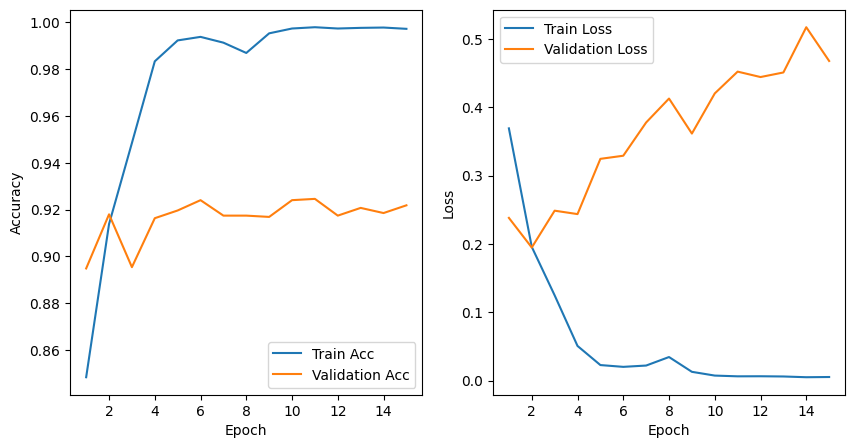

In [65]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

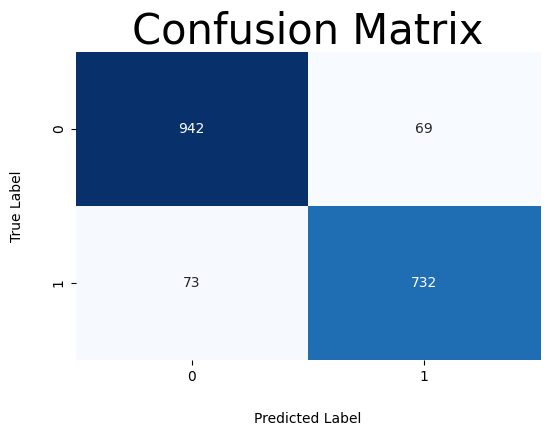

In [66]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [67]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.921
F1:        0.921
Precision: 0.921
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1011
           1       0.91      0.91      0.91       805

    accuracy                           0.92      1816
   macro avg       0.92      0.92      0.92      1816
weighted avg       0.92      0.92      0.92      1816



### 13.     In your opinion, what are the advantages and disadvantages of increasing the size of the context window, so that it is larger than the entire dataset, in a convolutional neural network.

In a convolutional neural network (CNN), the context window refers to the receptive field or the region of the input data that the network considers at a time. Increasing the size of the context window, especially to a size larger than the entire dataset, can have significant implications. Here are the advantages and disadvantages of such an approach:

#### Advantages

1. **Global Context Awareness**:
   - **Enhanced Feature Extraction**: A larger context window allows the network to consider the entire input at once, capturing global features and relationships that span the entire dataset. This can be beneficial for tasks where understanding the overall structure or context is crucial (e.g., scene recognition, sentiment analysis in long text sequences).
   - **Better Generalization**: By considering the entire dataset, the network might learn more generalized features that are not limited to local patterns. This could potentially improve the model's ability to generalize to new, unseen data.

2. **Reduced Information Loss**:
   - **Comprehensive View**: Larger context windows ensure that no part of the input is left out during the feature extraction process. This comprehensive view can be particularly useful in scenarios where every detail matters (e.g., medical imaging).

3. **Potential for Improved Performance**:
   - **Context-Rich Decisions**: With access to a larger context, the network can make more informed decisions. This can lead to improved accuracy and performance on tasks that benefit from understanding long-range dependencies.

#### Disadvantages

1. **Increased Computational Complexity**:
   - **Higher Resource Requirements**: A larger context window significantly increases the computational load. This includes more memory usage and longer training times, as the network needs to process larger amounts of data simultaneously.
   - **Inefficiency**: Processing the entire dataset at once can be inefficient, especially if the dataset is very large. It can lead to slow training and inference times, making the approach impractical for real-time applications.

2. **Risk of Overfitting**:
   - **Overfitting to Global Features**: By focusing on global features, the network might overfit to the specific patterns present in the training dataset. This could result in poor performance on new data that has different global patterns.
   - **Reduced Robustness**: The model may become less robust to variations in local patterns, as it might rely too heavily on global context.

3. **Complexity in Implementation**:
   - **Architecture Adjustments**: Increasing the context window size might require significant changes to the network architecture, including deeper or wider layers to handle the larger input effectively.
   - **Hyperparameter Tuning**: More extensive hyperparameter tuning might be necessary to balance the increased complexity and ensure effective learning.

4. **Diminishing Returns**:
   - **Marginal Gains**: After a certain point, increasing the context window size may result in diminishing returns. The additional context might not provide substantial new information beyond what is already captured, leading to unnecessary computational overhead without corresponding improvements in performance.


Increasing the size of the context window in a CNN can provide advantages such as enhanced feature extraction, better generalization, and reduced information loss. However, it also comes with significant drawbacks, including increased computational complexity, risk of overfitting, implementation challenges, and potential diminishing returns.



#### Analysis
We can see that increasing the context window size to 196 significantly increases the computational complexity of our model. However, the performance metrics show no significant improvement over the smaller context window size of 64. The results are quite similar, indicating that the larger context window does not provide additional benefits in terms of model accuracy, recall, precision, and F1-score.

Given this observation, the increased computational cost associated with the larger context window size does not justify its use. Instead, similar improvements in model performance could potentially be achieved through fine-tuning our model with the smaller context window size of 64. This approach would be more efficient and practical, allowing us to achieve high performance without the added computational burden.

By focusing on fine-tuning the model, we can optimize hyperparameters, adjust learning rates, and implement regularization techniques to enhance the model's effectiveness while maintaining computational efficiency. This strategy ensures that we leverage the strengths of the smaller context window size while avoiding unnecessary increases in computation time.

### 3: Regularization

In [68]:
class CNN_2(nn.Module):
    def __init__(self, input_size = 300, sequence_len_1_ = 64, sequence_len_2_ = 128, output_size = 2, flatt_size = 12288,  dropout_prob=0.5):
        super(CNN_2, self).__init__()
        self.conv1_1 = nn.Conv1d(input_size, sequence_len_1, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv1d(input_size, sequence_len_1, kernel_size=5, padding=2)
        self.conv1_3 = nn.Conv1d(input_size, sequence_len_1, kernel_size=7, padding=3)

        self.conv2_1 = nn.Conv1d(sequence_len_1, sequence_len_2, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv1d(sequence_len_1, sequence_len_2, kernel_size=5, padding=2)
        self.conv2_3 = nn.Conv1d(sequence_len_1, sequence_len_2, kernel_size=7, padding=3)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(flatt_size, sequence_len_2)
        self.fc2 = nn.Linear(sequence_len_2, output_size)

        self.dropout = nn.Dropout(dropout_prob)
        self.batchnorm1 = nn.BatchNorm1d(sequence_len_2)
        self.batchnorm2 = nn.BatchNorm1d(output_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.conv1_1(x))
        x2 = self.relu(self.conv1_2(x))
        x3 = self.relu(self.conv1_3(x))

        x1 = self.pool(self.relu(self.conv2_1(x1)))
        x2 = self.pool(self.relu(self.conv2_2(x2)))
        x3 = self.pool(self.relu(self.conv2_3(x3)))

        x_concatenated = torch.cat((x1, x2, x3), dim=1)

        x = x_concatenated.view(x_concatenated.size(0), -1)

        x = self.fc1(x)

        x = self.batchnorm1(x)

        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)

        x = self.batchnorm2(x)

        return x

In [69]:
input_size = 300
output_size = 2
sequence_len_1 = 64
sequence_len_2 = 128
loss_function = nn.CrossEntropyLoss()

EPOCHS = 15
LEARNING_RATE_1 = 0.0004
BATCH_SIZE_1 = 64


In [70]:
train_dataset = Twitter(train_df, w2v_model, sequence_len_1)
valid_dataset = Twitter(valid_df, w2v_model, sequence_len_1)

Deleted 0-Len Samples: 23
0           [feel, like, end, life, worth, live, without]
1       [surprise, meteor, come, fell, oo, want, die, ...
2       [try, help, friend, need, drain, life, note, c...
3       [im, really, worry, mathematics, subject, im, ...
4       [one, year, retirement, hope, enjoy, busy, pen...
                              ...                        
7267                                         [ugh, sorry]
7268    [forgot, duh, always, love, song, always, pers...
7269                                 [know, alpha, stamp]
7270    [lose, never, good, type, shit, amfed, life, w...
7271    [congratulation, take, asia, regional, final, ...
Name: tokens, Length: 7272, dtype: object
Deleted 0-Len Samples: 8
0                                             [die, want]
1       [suicide, rational, choice, hi, anonymous, cro...
2       [invasive, thought, depress, long, timei, amsu...
3        [ok, back, goin, orson, fake, dont, wan, na, go]
4                               [get,

In [71]:
cnn_model = CNN_2(input_size,sequence_len_1, sequence_len_2, output_size, int(3 * sequence_len_1 * sequence_len_2 * 0.5) ,0.5)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE_1)

In [72]:
cnn_model_train_history = train_model(
    model=cnn_model,
    batch_size=BATCH_SIZE_1,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device='auto'
)

Epoch 1 :
train_loss = 0.338071, train_acc = 0.868399, valid_loss =  0.302469, valid_acc = 0.894273
________________________________________


Epoch 2 :
train_loss = 0.247279, train_acc = 0.925880, valid_loss =  0.255701, valid_acc = 0.911344
________________________________________


Epoch 3 :
train_loss = 0.188152, train_acc = 0.960946, valid_loss =  0.235817, valid_acc = 0.913546
________________________________________


Epoch 4 :
train_loss = 0.146933, train_acc = 0.984461, valid_loss =  0.259929, valid_acc = 0.904185
________________________________________


Epoch 5 :
train_loss = 0.120219, train_acc = 0.993812, valid_loss =  0.261531, valid_acc = 0.913546
________________________________________


Epoch 6 :
train_loss = 0.106637, train_acc = 0.995187, valid_loss =  0.243536, valid_acc = 0.918502
________________________________________


Epoch 7 :
train_loss = 0.097141, train_acc = 0.996287, valid_loss =  0.223649, valid_acc = 0.915198
________________________________________


Epoch 8 :
train_loss = 0.087051, train_acc = 0.997250, valid_loss =  0.234426, valid_acc = 0.915198
________________________________________


Epoch 9 :
train_loss = 0.080744, train_acc = 0.997387, valid_loss =  0.227710, valid_acc = 0.917401
________________________________________


Epoch 10 :
train_loss = 0.076923, train_acc = 0.996975, valid_loss =  0.220271, valid_acc = 0.919053
________________________________________


Epoch 11 :
train_loss = 0.072529, train_acc = 0.997387, valid_loss =  0.224134, valid_acc = 0.921806
________________________________________


Epoch 12 :
train_loss = 0.067166, train_acc = 0.997937, valid_loss =  0.225189, valid_acc = 0.917952
________________________________________


Epoch 13 :
train_loss = 0.064601, train_acc = 0.997662, valid_loss =  0.220679, valid_acc = 0.917401
________________________________________


Epoch 14 :
train_loss = 0.061268, train_acc = 0.997937, valid_loss =  0.214821, valid_acc = 0.922357
________________________________________


Epoch 15 :
train_loss = 0.058704, train_acc = 0.997525, valid_loss =  0.227193, valid_acc = 0.919053
________________________________________


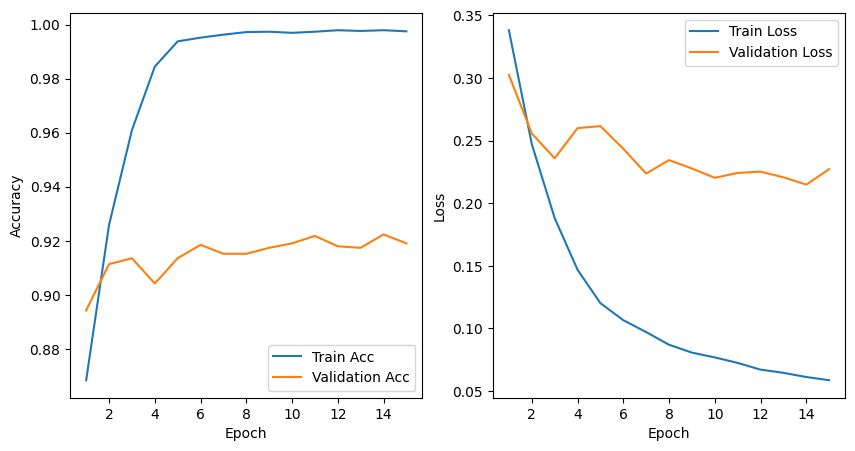

In [73]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

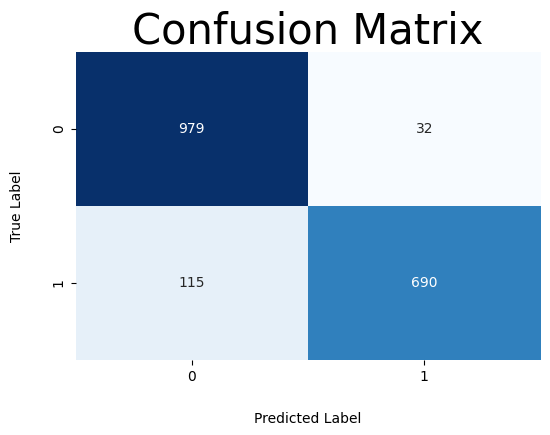

In [74]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [75]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.913
F1:        0.917
Precision: 0.925
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1011
           1       0.96      0.86      0.90       805

    accuracy                           0.92      1816
   macro avg       0.93      0.91      0.92      1816
weighted avg       0.92      0.92      0.92      1816



By adding Dropout and Batch Normalization layers to the neural network, we observed improvements in the model's performance metrics, including recall, F1-score, precision, and accuracy. These regularization methods helped reduce overfitting, leading to better generalization and robustness to variations in input data.

To further optimize the architecture, additional experimentation with different dropout rates and batch normalization configurations can be conducted. Comparing these results with previous ones clearly demonstrates the benefits of incorporating regularization techniques in neural network training.